# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook, data_wrangler, haversine
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [2]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,9,0,0),
                minmagnitude=4.9,
                maxmagnitude=6.4,
                maxradiuskm=1000, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))
 

Returned 10 events


### Choose an event to analyze

In [3]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df




#event_df.iloc[0::]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
9,nc73827571,2023-01-01 18:35:04.510,"15km SE of Rio Dell, CA",40.409000,-123.971000,30.630,5.35,yellow,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1352
8,nc73821046,2022-12-20 10:39:02.360,"7km WNW of Rio Dell, CA",40.522833,-124.188167,26.550,4.92,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,458
7,nc73821036,2022-12-20 10:34:24.770,"15km WSW of Ferndale, CA",40.525000,-124.423000,17.910,6.40,orange,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1780
6,us6000j8c6,2022-12-10 03:17:30.125,"257 km W of Ferndale, California",40.622100,-127.305900,11.051,4.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,372
5,us7000ishe,2022-11-26 03:50:17.526,"18 km NW of Tofino, Canada",49.271400,-126.092300,33.380,4.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,527
4,us7000irbr,2022-11-21 15:42:33.590,None,43.487400,-127.338200,10.000,5.20,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,429
3,us7000hhik,2022-06-15 11:56:33.191,off the coast of Oregon,44.538100,-130.112400,10.000,5.60,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,487
2,us7000hf29,2022-06-04 23:59:10.007,"Haida Gwaii Region, Canada",51.613700,-131.402700,6.610,5.10,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,401
1,us6000hfx7,2022-04-23 21:22:47.948,"185 km W of Port McNeill, Canada",50.472500,-129.689500,10.000,5.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,435
0,us7000gxl1,2022-03-27 01:12:22.059,off the coast of Oregon,44.122900,-129.438500,10.000,5.10,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,404


In [4]:
dist_kmarray = []
magnituddarray = []
thisid = []
PGM = []
PGA1 = []
PGA2 = []
PGA3 = []
PGV = []

In [5]:
for index,this_event in event_df.iterrows():
    
    this_id = this_event['id']
    
    this_event_new = event_df[event_df.id==this_id]
    
    latitude_loc = this_event_new['latitude']
    longitude_loc = this_event_new['longitude']
    latitude_ref = 47.60
    longitude_ref = -122.33
    
    coords_1 = (this_event_new.latitude.to_numpy()[0], this_event_new.longitude.to_numpy()[0])
    coords_2 = (47.6531, -122.3079)
    dist_km = geopy.distance.geodesic(coords_1, coords_2).km
    
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    #print(distance)
    
    if  dist_km  <500:#if when I want to avoid the previus datas
           continue
    magnituddarray.append(this_event_new['magnitude'].to_numpy()[0])
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    thisid.append(this_id)
    dist_kmarray.append(dist_km)
    #if distance < 500:
    #    continue
    
    print(this_event['id'])
    
    stitle=f"M {this_event_new['magnitude'].to_numpy()[0]}, "\
           f"{this_event_new['location'].to_numpy()[0]}, "\
           f"{str(this_event_new['time'].to_numpy()[0])[0:-10]} UTC"
      

    record_length = 20 #minutes
    t0 = this_event_new['time'].iloc[0]
    
    low_cut = 2
    hi_cut = 10

    try:
        client = Client("IRIS")

        t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
        dt = datetime.timedelta(minutes=record_length)
        t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )
        
        
        pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
        st = client.get_waveforms("UW", "PRIN", "--", "HHZ", t1, t2, attach_response=True)
         #st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
        st2 = client.get_waveforms("UW", "SALO", "--", "HHZ", t1, t2, attach_response=True)
        st3 = client.get_waveforms("UW", "CHIMA", "--", "HHZ", t1, t2, attach_response=True)

        
        st.remove_response(output='ACC', pre_filt=pre_filt)
        st2.remove_response(output='ACC', pre_filt=pre_filt)
        st3.remove_response(output='ACC', pre_filt=pre_filt)
            
        peak_ground_acceleration1 = np.max(np.abs(st[0].data))
        peak_ground_acceleration2 = np.max(np.abs(st2[0].data))
        peak_ground_acceleration3 = np.max(np.abs(st3[0].data))
        PGA1.append(peak_ground_acceleration1)
        PGA2.append(peak_ground_acceleration2)
        PGA3.append(peak_ground_acceleration3)
            

        
    except ValueError:
        continue



nc73827571
nc73821046
nc73821036
us6000j8c6
us7000irbr
us7000hhik
us7000hf29
us6000hfx7
us7000gxl1


In [6]:
#magnituddarray
#magnituddarray

thisid
 
#magnituddarray


#dist_kmarray

['nc73827571',
 'nc73821046',
 'nc73821036',
 'us6000j8c6',
 'us7000irbr',
 'us7000hhik',
 'us7000hf29',
 'us6000hfx7',
 'us7000gxl1']

In [7]:
PGA1


[0.00014676529735211681,
 2.7106757665263124e-05,
 0.00023702993147022315,
 9.77407274406583e-05,
 0.00017966388144438243,
 0.0006131192043852006,
 0.0004012931679924587,
 0.0007624033781606861,
 0.0002063824559199374]

In [8]:
PGA2

[3.819134612851734e-05,
 1.0589585117774427e-05,
 8.16650915703709e-05,
 1.8484399729369492e-05,
 4.440762963135678e-05,
 9.502901031707749e-05,
 2.05268894708674e-05,
 6.755943488887679e-05,
 0.00014664570784810678]

In [9]:
PGA3

[9.570643212228681e-05,
 0.00010130136613706426,
 8.916017693616317e-05,
 0.00011200735759414025,
 0.0004884158404919962,
 0.0002524939063825508,
 0.0003597719869457546,
 0.0001791568354482955,
 0.00010524552643150822]

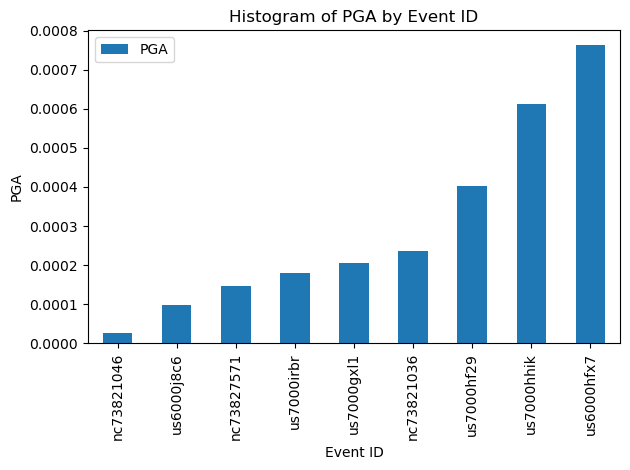

In [10]:
data1 = pd.DataFrame({'Event ID': thisid, 'PGA': PGA1})
data1.set_index('Event ID', inplace=True)
data1 = data1.sort_values('PGA', ascending=True)
data1.plot.bar(legend=True)
#plt.xlabel('Event ID')
plt.ylabel('PGA')
plt.title('Histogram of PGA by Event ID')
plt.xticks(rotation='vertical')
plt.tight_layout()

plt.show()

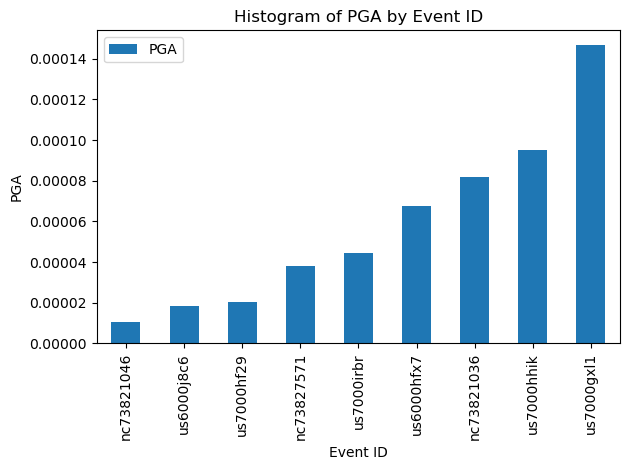

In [11]:
data2 = pd.DataFrame({'Event ID': thisid, 'PGA': PGA2})
data2.set_index('Event ID', inplace=True)
data2 = data2.sort_values('PGA', ascending=True)
data2.plot.bar(legend=True)
#plt.xlabel('Event ID')
plt.ylabel('PGA')
plt.title('Histogram of PGA by Event ID')
plt.xticks(rotation='vertical')
plt.tight_layout()

plt.show()

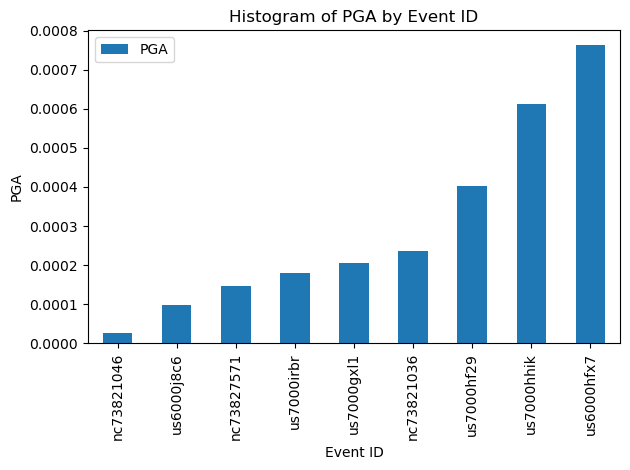

In [12]:
data3 = pd.DataFrame({'Event ID': thisid, 'PGA': PGA3})
data3.set_index('Event ID', inplace=True)
data3 = data3.sort_values('PGA', ascending=True)
data1.plot.bar(legend=True)
#plt.xlabel('Event ID')
plt.ylabel('PGA')
plt.title('Histogram of PGA by Event ID')
plt.xticks(rotation='vertical')
plt.tight_layout()

plt.show()

# Testing waveforms


In [13]:
#st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)
#st2.remove_response(output='VEL', pre_filt=pre_filt).max
#st2.remove_response(output='ACC', pre_filt=pre_filt)
#peak_ground_acceleration2 = np.max(np.abs(st2[0].data))
#st2.plot() 

In [14]:
clip = pd.read_csv('Clippedanalisis3.csv')
clip

,Magnitud,id_event,Location,detect_seismO,detect_das,clipped,channels,PGA(SALO)
0,5.35,nc73827571,815.823922,NaN,TRUE,TRUE,NaN,3.82E-05
1,4.92,nc73821046,806.386428,NaN,TRUE,TRUE,NaN,1.06E-05
2,4.90,us6000j8c6,877.203601,NaN,FALSE,FALSE,NaN,1.85E-05
3,5.20,us7000irbr,606.808105,NaN,TRUE,TRUE,NaN,4.44E-05
4,5.60,us7000hhik,695.303477,NaN,norecord,FALSE,NaN,norecord
5,5.10,us7000hf29,790.117236,NaN,TRUE,FALSE,NaN,2.05E-05
6,5.30,us6000hfx7,623.530865,NaN,norecord,FALSE,NaN,norecord
7,5.10,us7000gxl1,677.999050,NaN,TRUE,FALSE,NaN,1.47E-04
8,6.40,nc73821036,809.854647,NaN,TRUE,TRUE,NaN,8.17E-05
